In [136]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd
import requests
import json
import re
from matplotlib import pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon
import time
from geopy import distance
from tqdm import tqdm_notebook as tqdm


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

In [137]:
train = pd.read_csv('data/mf_geo_train.csv')
test = pd.read_csv('data/mf_geo_test.csv')

In [138]:
train.head(2)

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206


In [139]:
test.head(2)

,point_id,lon,lat,target
0,F4lXR1cG,37.681242,55.74804,0.0091
1,4LJu4GTf,60.580910,56.79586,0.0091


### Fit model

In [140]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train[['target']])
model = LinearRegression().fit(X_train.drop('point_id', axis=1), y_train)

In [141]:
mean_absolute_error(y_valid, model.predict(X_valid.drop('point_id', axis=1)))

0.6030740204030213

### Make submission

In [142]:
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = model.predict(X_valid.drop('point_id', axis=1))
submission.to_csv('data/my_submission_01.csv', index=False)

# Приступим. Для начала опредилим к какому городу относится каждый салон.

In [143]:
# Установим все необходимое
# %pip install geopy
# %pip install nominatim

# 1.1 Получим данные о городе с помощью обратного геокодирования.

Объединим колонки широты и долготы

In [144]:
train['lat_lon'] = train[['lat', 'lon']].apply(
    lambda x: ', '.join(x.astype(str)),
    axis=1
)
train.head()

,point_id,lon,lat,target,lat_lon
0,ommNZCUV,37.590776,55.848630,-0.348157,"55.84863000000001, 37.590776"
1,nMe2LHPb,37.784210,55.750271,1.294206,"55.750271, 37.78421"
2,ZgodVRqB,39.635721,47.213330,-1.039679,"47.21333, 39.635721"
3,0t2jNYdz,37.704570,55.782020,-1.169339,"55.78202, 37.70457"
4,U27W4QJ7,37.643983,55.730188,-0.088837,"55.730188, 37.643983"


С помощью обратного геокодирования получим необходимую информацию о точках

In [145]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='https://www.openstreetmap.org/')
# overpass_url = 'https://overpass.openstreetmap.ru'

In [147]:
%%time
train['point_inf'] = train['lat_lon'].apply(
    lambda x: geolocator.reverse(x).raw
)
train

In [ ]:
train.to_csv('data/train_with_point_inf')

In [ ]:
df = pd.read_csv('data/train_with_point_inf')
df

Далее вытаскиваем из словаря название города

In [ ]:
df['city'] = train['point_inf'].apply(
    lambda x: x['address'].get('city')
)

In [ ]:
df['point_inf'][0]

In [ ]:
df['city'].value_counts()

# 1.2. Пересечение точек с границами АТД. 
Скачаем необходимую информацию в формате .geojson отсюда: https://mydata.biz/ru/catalog/databases/borders_ru

In [148]:
import tempfile, os, zipfile

In [ ]:
# url = 'https://mydata.biz/storage/download/' +\
# '94711ccda7f04a0ba9216d3483b4ad4c/' +\
# '%D0%90%D0%B4%D0%BC-%D1%82%D0%B5%D1%80%D1%80%D0%' +\
# 'B8%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%' +\
# 'BD%D1%8B%D0%B5%20%D0%B3%D1%80%D0%B0%D0%BD%D0%B8%' +\
# 'D1%86%D1%8B%20%D0%A0%D0%A4%20%D0%B2%20%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%82%D0%B5%20' +\
# 'GeoJSON.zip'

# response = requests.get(url)
# file = tempfile.TemporaryFile()
# file.write(response.content)
# fzip = zipfile.ZipFile(file)
# fzip.extractall('data/ru_atd')
# file.close()
# fzip.close()

In [149]:
adm_level_4 = gpd.read_file('data/ru_atd/admin_level_4.geojson')

In [150]:
adm_level_6 = gpd.read_file('data/ru_atd/admin_level_6.geojson')

<AxesSubplot:>

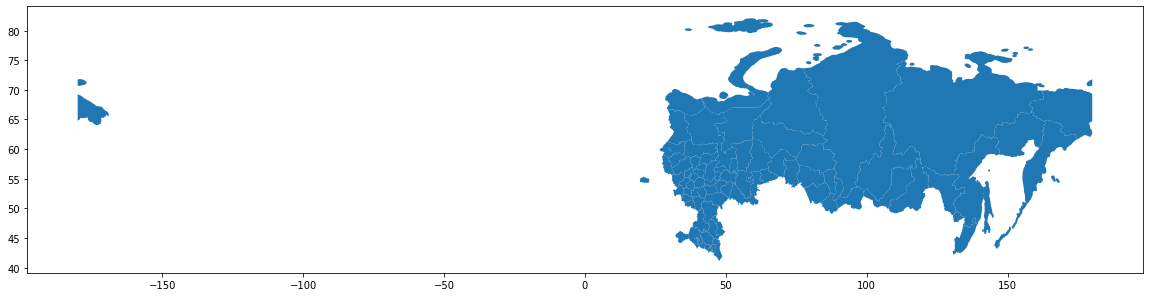

In [151]:
adm_level_4.plot(figsize=(20, 15))

<AxesSubplot:>

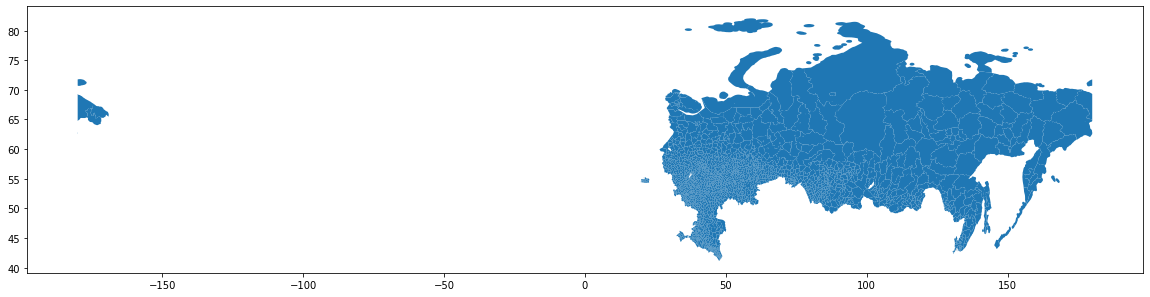

In [152]:
adm_level_6.plot(figsize=(20, 15))

<AxesSubplot:>

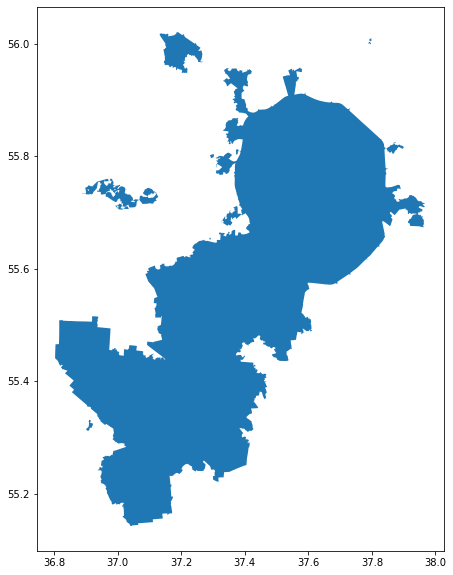

In [153]:
adm_level_4[adm_level_4['name'] == 'Москва'].plot(figsize=(20, 10))

Реализуем функцию, которая объединяет наши точки с границами

In [154]:
def define_area(df_):
    gdf = gpd.GeoDataFrame(
        df_, geometry=gpd.points_from_xy( df_.lon, df_.lat)
    )
    # Сначала заджоиним с более крупным дроблением АТД
    gdf = gpd.sjoin(gdf, adm_level_4[['name', 'geometry']], how='left')
    gdf.drop('index_right', axis=1, inplace=True)
    # Теперь с более мелким
    gdf = gpd.sjoin(gdf, adm_level_6[['name', 'geometry']], how='left')
    gdf['name_right'] = gdf['name_right'].fillna(gdf['name_left'])
    # Уберем ненужные столбцы
    gdf['name'] =  gdf['name_right']
    gdf.drop(columns=['name_left', 'index_right', 'name_right'], inplace=True)
    return gdf

In [155]:
gdf = define_area(train)

In [156]:
gdf['name'].value_counts()

Москва                             161
Санкт-Петербург                     83
городской округ Самара              27
городской округ Новосибирск         26
городской округ Казань              25
городской округ Екатеринбург        22
городской округ Ростов-на-Дону      21
городской округ Нижний Новгород     21
городской округ Красноярск          20
городской округ Уфа                 19
Name: name, dtype: int64

# Добавление признаков

Добавим в таблицу буферные зоны для каждой координаты. Примерное расстояние в 300 метров. http://bboxfinder.com/#55.750633,37.616142,55.756012,37.625700

In [548]:
import pyproj
from shapely.ops import transform

In [536]:
def buff_zone_200(point: Point):
    wgs84 = pyproj.CRS('EPSG:4326')
    utm = pyproj.CRS('EPSG:32618')
    transform_point = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
    reverse_transform = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
    point_t = transform(transform_point, point)
    area = point_t.buffer(200)
    area_reverse = transform(reverse, area)
    return area_reverse

def buff_zone_300(point: Point):
    wgs84 = pyproj.CRS('EPSG:4326')
    utm = pyproj.CRS('EPSG:32618')
    transform_point = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
    reverse_transform = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
    point_t = transform(transform_point, point)
    area = point_t.buffer(300)
    area_reverse = transform(reverse, area)
    return area_reverse

def buff_zone_500(point: Point):
    wgs84 = pyproj.CRS('EPSG:4326')
    utm = pyproj.CRS('EPSG:32618')
    transform_point = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
    reverse_transform = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
    point_t = transform(transform_point, point)
    area = point_t.buffer(500)
    area_reverse = transform(reverse, area)
    return area_reverse

In [545]:
gdf['buffer_200'] = gdf['geometry'].apply(buff_zone_200)

In [544]:
gdf['buffer_300'] = gdf['geometry'].apply(buff_zone_300)

In [543]:
gdf['buffer_500'] = gdf['geometry'].apply(buff_zone_500)

In [547]:
gdf.head()

,point_id,lon,lat,target,lat_lon,point_inf,geometry,name,buffer_300,buffer_200,buffer_500
0,ommNZCUV,37.590776,55.848630,-0.348157,"55.84863000000001, 37.590776","{'place_id': 113422944, 'licence': 'Data © Ope...",POINT (37.59078 55.84863),Москва,"POLYGON ((37.58894 55.84657, 37.58859 55.84668...","POLYGON ((37.58955 55.84726, 37.58932 55.84733...","POLYGON ((37.58771 55.84520, 37.58713 55.84538..."
1,nMe2LHPb,37.784210,55.750271,1.294206,"55.750271, 37.78421","{'place_id': 218413796, 'licence': 'Data © Ope...",POINT (37.78421 55.75027),Москва,"POLYGON ((37.78236 55.74822, 37.78201 55.74833...","POLYGON ((37.78298 55.74890, 37.78274 55.74898...","POLYGON ((37.78113 55.74685, 37.78055 55.74703..."
2,ZgodVRqB,39.635721,47.213330,-1.039679,"47.21333, 39.635721","{'place_id': 102334776, 'licence': 'Data © Ope...",POINT (39.63572 47.21333),городской округ Ростов-на-Дону,"POLYGON ((39.63407 47.21153, 39.63382 47.21165...","POLYGON ((39.63462 47.21213, 39.63445 47.21221...","POLYGON ((39.63297 47.21033, 39.63255 47.21052..."
3,0t2jNYdz,37.704570,55.782020,-1.169339,"55.78202, 37.70457","{'place_id': 104305978, 'licence': 'Data © Ope...",POINT (37.70457 55.78202),Москва,"POLYGON ((37.70272 55.77996, 37.70238 55.78007...","POLYGON ((37.70334 55.78065, 37.70311 55.78072...","POLYGON ((37.70149 55.77859, 37.70091 55.77878..."
4,U27W4QJ7,37.643983,55.730188,-0.088837,"55.730188, 37.643983","{'place_id': 128928092, 'licence': 'Data © Ope...",POINT (37.64398 55.73019),Москва,"POLYGON ((37.64214 55.72813, 37.64180 55.72824...","POLYGON ((37.64276 55.72882, 37.64253 55.72889...","POLYGON ((37.64092 55.72676, 37.64034 55.72695..."


In [36]:
# %pip install overpass

In [37]:
import overpass

In [38]:
api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter")

Сперва определим bbox для каждого города для поиска объектов.

In [316]:
areas = dict()
for area in gdf['name'].unique():
    areas[area] = None

def bbox_extracting(gdf):
    for area in areas:
        if area in adm_level_6['name'].values:
            b = adm_level_6[adm_level_6['name'] == area]['geometry'].bounds
            areas[area] = f"{b.miny.values[0]},{b.minx.values[0]},{b.maxy.values[0]},{b.maxx.values[0]}"
        else:
            b = adm_level_4[adm_level_4['name'] == area]['geometry'].bounds
            areas[area] = f"{b.miny.values[0]},{b.minx.values[0]},{b.maxy.values[0]},{b.maxx.values[0]}"
    return areas

In [71]:
areas_bbox = bbox_extracting(gdf)
areas_bbox

{'Москва': '55.1421745,36.8031012,56.0212238,37.967427699999995',
 'городской округ Ростов-на-Дону': '47.1523996,39.4047313,47.36873280000001,39.85244709999999',
 'городской округ Красноярск': '55.91184049999999,92.62713199999999,56.13379580000001,93.16856109999999',
 'Санкт-Петербург': '59.6337832,29.4298103,60.2448369,30.7596912',
 'городской округ Уфа': '54.5007506,55.77865310000001,54.959874899999996,56.298555700000016',
 'городской округ Казань': '55.603478,48.8205846,55.9382194,49.381246899999994',
 'городской округ Екатеринбург': '56.5968406,60.007353800000004,56.9824668,60.9432759',
 'городской округ Нижний Новгород': '56.1559621,43.5487835,56.422045100000005,44.1547721',
 'городской округ Новосибирск': '54.8009231,82.75171300000001,55.199819600000005,83.1609969',
 'городской округ Самара': '53.0916732,49.746897,53.551892099999996,50.3903893'}

In [72]:
def get_bbox_bus_stops(bbox):
    response = api.get(f"""
        node["highway"="bus_stop"]
        ({bbox})
    """)
    return response

Пересечем точки объектов с полигонами АТД

In [76]:
def bound_obj(gdf, get_func):
    dict_objects = dict()
    for area in areas_bbox:
        response = get_func(areas_bbox[area])
        response_df = gpd.GeoDataFrame(response['features'])
#         if response_df.shape[0] == 0:
#             dict_objects[area] = None
#             continue
        if area in adm_level_6['name'].values:
            response_df = gpd.sjoin(response_df, adm_level_6[adm_level_6['name'] == area][['geometry']])
            response_df.plot()
            dict_objects[area] = response_df.geometry.values
        else:
            response_df = gpd.sjoin(response_df, adm_level_4[adm_level_4['name'] == area][['geometry']])
            response_df.plot()
            dict_objects[area] = response_df.geometry.values
    return dict_objects

CPU times: user 19.9 s, sys: 350 ms, total: 20.3 s
Wall time: 2min 4s


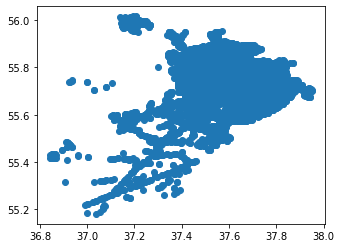

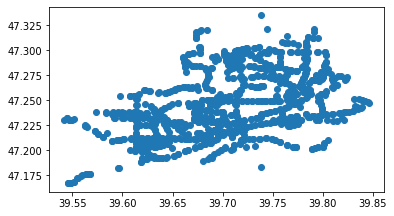

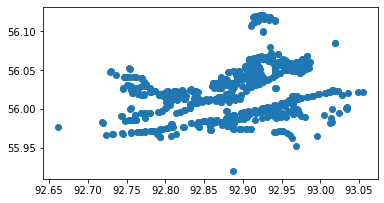

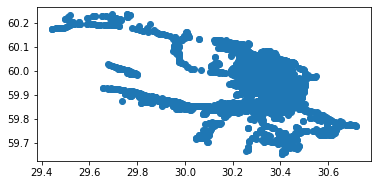

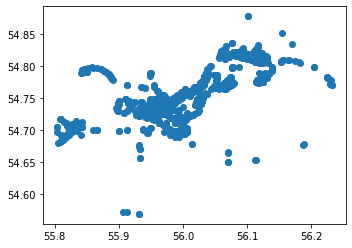

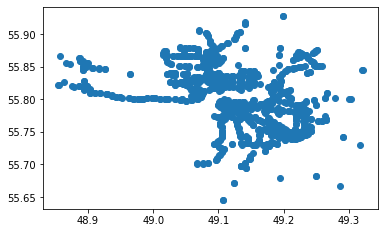

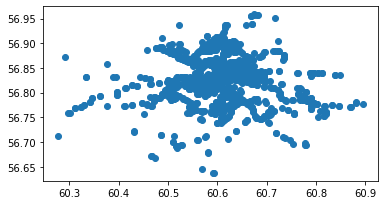

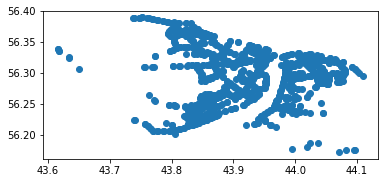

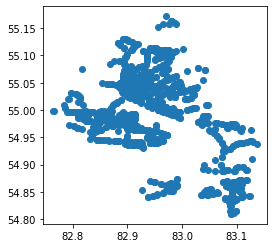

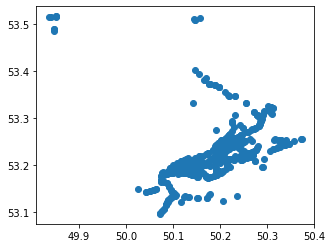

In [77]:
%%time
bus_stops = bound_obj(gdf, get_bbox_bus_stops)

In [78]:
bus_stops

{'Москва': <GeometryArray>
  ...
 Length: 10685, dtype: geometry,
 'городской округ Ростов-на-Дону': <GeometryArray>
  ...
 Length: 1087, dtype: geometry,
 'городской округ Красноярск': <GeometryArray>
  ...
 Length: 669, dtype: geometry,
 'Санкт-Петербург': <GeometryArray>
  ...
 Length: 4852, dtype: geometry,
 'городской округ Уфа': <GeometryArray>
  ...
 Length: 662, dtype: geometry,
 'городской округ Казань': <GeometryArray>
  ...
 Length: 1105, dtype: geometry,
 'городской округ Екатеринбург': <GeometryArray>
  ...
 Length: 1093, dtype: geometry,
 'городской округ Нижний Новгород': <GeometryArray>
  ...
 Length: 1074, dtype: geometry,
 'городской округ Новосибирск': <GeometryArray>
  ...
 Length: 1062, dtype: geometry,
 'городской округ Самара': <GeometryArray>
  ...
 Length: 602, dtype: geometry}

In [80]:
gdf.head(3)

,point_id,lon,lat,target,lat_lon,point_inf,geometry,name,buffer_200,buffer_300,buffer_500
0,ommNZCUV,37.590776,55.848630,-0.348157,"55.84863000000001, 37.590776","{'place_id': 113422944, 'licence': 'Data © Ope...",POINT (37.59078 55.84863),Москва,"POLYGON ((37.58955 55.84726, 37.58932 55.84733...","POLYGON ((37.58894 55.84657, 37.58859 55.84668...","POLYGON ((37.58771 55.84520, 37.58713 55.84538..."
1,nMe2LHPb,37.784210,55.750271,1.294206,"55.750271, 37.78421","{'place_id': 218413796, 'licence': 'Data © Ope...",POINT (37.78421 55.75027),Москва,"POLYGON ((37.78298 55.74890, 37.78274 55.74898...","POLYGON ((37.78236 55.74822, 37.78201 55.74833...","POLYGON ((37.78113 55.74685, 37.78055 55.74703..."
2,ZgodVRqB,39.635721,47.213330,-1.039679,"47.21333, 39.635721","{'place_id': 102334776, 'licence': 'Data © Ope...",POINT (39.63572 47.21333),городской округ Ростов-на-Дону,"POLYGON ((39.63462 47.21213, 39.63445 47.21221...","POLYGON ((39.63407 47.21153, 39.63382 47.21165...","POLYGON ((39.63297 47.21033, 39.63255 47.21052..."


Таким образом получили словарь с остановками.
Далее напишем функцию, которая определяет количество остановок в буферной зоне для каждой точки

In [81]:
def intersections(name, buffer, dict_objects):  
    local_multi_point = MultiPoint(dict_objects[name])
    try:
        return(len(buffer.intersection(local_multi_point)))
    except:
        return 0

In [82]:
gdf['bus_stops_count_200'] = [
    intersections(name, buffer, bus_stops) for name, buffer in tqdm(zip(gdf['name'], gdf['buffer_200']))
]

0it [00:00, ?it/s]

In [83]:
gdf.head()

,point_id,lon,lat,target,lat_lon,point_inf,geometry,name,buffer_200,buffer_300,buffer_500,bus_stops_count_200
0,ommNZCUV,37.590776,55.848630,-0.348157,"55.84863000000001, 37.590776","{'place_id': 113422944, 'licence': 'Data © Ope...",POINT (37.59078 55.84863),Москва,"POLYGON ((37.58955 55.84726, 37.58932 55.84733...","POLYGON ((37.58894 55.84657, 37.58859 55.84668...","POLYGON ((37.58771 55.84520, 37.58713 55.84538...",4
1,nMe2LHPb,37.784210,55.750271,1.294206,"55.750271, 37.78421","{'place_id': 218413796, 'licence': 'Data © Ope...",POINT (37.78421 55.75027),Москва,"POLYGON ((37.78298 55.74890, 37.78274 55.74898...","POLYGON ((37.78236 55.74822, 37.78201 55.74833...","POLYGON ((37.78113 55.74685, 37.78055 55.74703...",5
2,ZgodVRqB,39.635721,47.213330,-1.039679,"47.21333, 39.635721","{'place_id': 102334776, 'licence': 'Data © Ope...",POINT (39.63572 47.21333),городской округ Ростов-на-Дону,"POLYGON ((39.63462 47.21213, 39.63445 47.21221...","POLYGON ((39.63407 47.21153, 39.63382 47.21165...","POLYGON ((39.63297 47.21033, 39.63255 47.21052...",3
3,0t2jNYdz,37.704570,55.782020,-1.169339,"55.78202, 37.70457","{'place_id': 104305978, 'licence': 'Data © Ope...",POINT (37.70457 55.78202),Москва,"POLYGON ((37.70334 55.78065, 37.70311 55.78072...","POLYGON ((37.70272 55.77996, 37.70238 55.78007...","POLYGON ((37.70149 55.77859, 37.70091 55.77878...",4
4,U27W4QJ7,37.643983,55.730188,-0.088837,"55.730188, 37.643983","{'place_id': 128928092, 'licence': 'Data © Ope...",POINT (37.64398 55.73019),Москва,"POLYGON ((37.64276 55.72882, 37.64253 55.72889...","POLYGON ((37.64214 55.72813, 37.64180 55.72824...","POLYGON ((37.64092 55.72676, 37.64034 55.72695...",2


На мой взгляд неплохим признаком является принадлежность салона (или близкое расстояние) к торговому центру.
Для каждой координаты салона, определим 500 метровую окрестность, и проверим: попадает ли в нее ТРЦ.

In [84]:
def get_malls(bbox):
    response = api.get(f"""
        node["shop"="mall"]
        ({bbox})
    """)
    return response

Проворачиваем те же действия, что и с автобусными остановками

CPU times: user 2.47 s, sys: 43.8 ms, total: 2.52 s
Wall time: 15.1 s


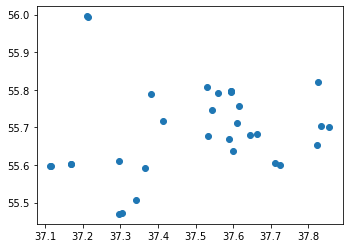

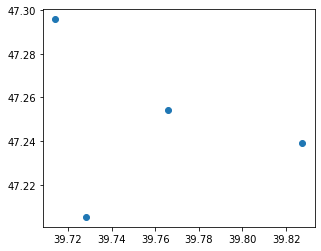

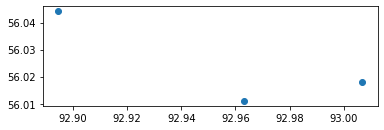

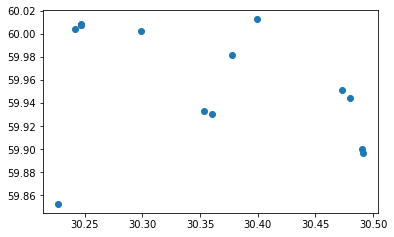

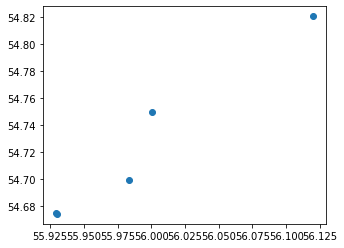

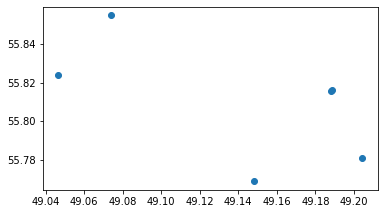

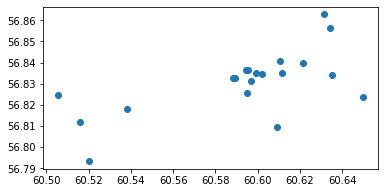

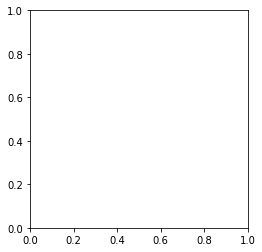

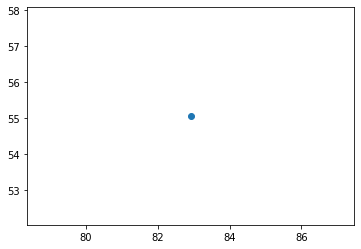

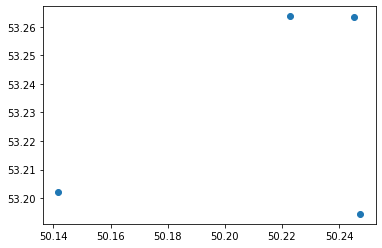

In [85]:
%%time
malls = bound_obj(gdf, get_malls)

In [86]:
gdf['malls_count_500'] = [
    intersections(name, point, malls) for name, point in tqdm(zip(gdf['name'], gdf['buffer_500']))
]

0it [00:00, ?it/s]

In [87]:
gdf.head(3)

,point_id,lon,lat,target,lat_lon,point_inf,geometry,name,buffer_200,buffer_300,buffer_500,bus_stops_count_200,malls_count_500
0,ommNZCUV,37.590776,55.848630,-0.348157,"55.84863000000001, 37.590776","{'place_id': 113422944, 'licence': 'Data © Ope...",POINT (37.59078 55.84863),Москва,"POLYGON ((37.58955 55.84726, 37.58932 55.84733...","POLYGON ((37.58894 55.84657, 37.58859 55.84668...","POLYGON ((37.58771 55.84520, 37.58713 55.84538...",4,0
1,nMe2LHPb,37.784210,55.750271,1.294206,"55.750271, 37.78421","{'place_id': 218413796, 'licence': 'Data © Ope...",POINT (37.78421 55.75027),Москва,"POLYGON ((37.78298 55.74890, 37.78274 55.74898...","POLYGON ((37.78236 55.74822, 37.78201 55.74833...","POLYGON ((37.78113 55.74685, 37.78055 55.74703...",5,0
2,ZgodVRqB,39.635721,47.213330,-1.039679,"47.21333, 39.635721","{'place_id': 102334776, 'licence': 'Data © Ope...",POINT (39.63572 47.21333),городской округ Ростов-на-Дону,"POLYGON ((39.63462 47.21213, 39.63445 47.21221...","POLYGON ((39.63407 47.21153, 39.63382 47.21165...","POLYGON ((39.63297 47.21033, 39.63255 47.21052...",3,0


Функция для определения расстояния

Определим координаты центров городов

In [88]:
def get_centers():
    centers = dict()
    for area in areas_bbox:
        for lvl in range (1, 9):
            response = api.get(f"""
            node[admin_level={lvl}]['name'='{area.replace('городской округ ', '')}']
            """)
            response_df = gpd.GeoDataFrame(response['features'])
            if response_df.shape[0] != 0:
                break
        centers[area] = response_df.geometry.values
    return centers

In [89]:
centers = get_centers()

In [90]:
centers

{'Москва': <GeometryArray>
 Length: 1, dtype: geometry,
 'городской округ Ростов-на-Дону': <GeometryArray>
 Length: 1, dtype: geometry,
 'городской округ Красноярск': <GeometryArray>
 Length: 1, dtype: geometry,
 'Санкт-Петербург': <GeometryArray>
 Length: 1, dtype: geometry,
 'городской округ Уфа': <GeometryArray>
 Length: 1, dtype: geometry,
 'городской округ Казань': <GeometryArray>
 Length: 1, dtype: geometry,
 'городской округ Екатеринбург': <GeometryArray>
 Length: 1, dtype: geometry,
 'городской округ Нижний Новгород': <GeometryArray>
 Length: 1, dtype: geometry,
 'городской округ Новосибирск': <GeometryArray>
 Length: 1, dtype: geometry,
 'городской округ Самара': <GeometryArray>
 Length: 1, dtype: geometry}

Добавим в датафрейм расстояние точек до центров

In [91]:
from geopy import distance

In [92]:
def center_dist(name, point):
    point_coord = point.y, point.x
    center_coord = centers[name].y[0], centers[name].x[0]
    return round(distance.geodesic(point_coord, center_coord).m)

In [93]:
gdf['center_dist'] = [
    center_dist(name, point) for name, point in tqdm(zip(gdf['name'], gdf['geometry']))
]

0it [00:00, ?it/s]

In [94]:
gdf.head(3)

,point_id,lon,lat,target,lat_lon,point_inf,geometry,name,buffer_200,buffer_300,buffer_500,bus_stops_count_200,malls_count_500,center_dist
0,ommNZCUV,37.590776,55.848630,-0.348157,"55.84863000000001, 37.590776","{'place_id': 113422944, 'licence': 'Data © Ope...",POINT (37.59078 55.84863),Москва,"POLYGON ((37.58955 55.84726, 37.58932 55.84733...","POLYGON ((37.58894 55.84657, 37.58859 55.84668...","POLYGON ((37.58771 55.84520, 37.58713 55.84538...",4,0,11059
1,nMe2LHPb,37.784210,55.750271,1.294206,"55.750271, 37.78421","{'place_id': 218413796, 'licence': 'Data © Ope...",POINT (37.78421 55.75027),Москва,"POLYGON ((37.78298 55.74890, 37.78274 55.74898...","POLYGON ((37.78236 55.74822, 37.78201 55.74833...","POLYGON ((37.78113 55.74685, 37.78055 55.74703...",5,0,10469
2,ZgodVRqB,39.635721,47.213330,-1.039679,"47.21333, 39.635721","{'place_id': 102334776, 'licence': 'Data © Ope...",POINT (39.63572 47.21333),городской округ Ростов-на-Дону,"POLYGON ((39.63462 47.21213, 39.63445 47.21221...","POLYGON ((39.63407 47.21153, 39.63382 47.21165...","POLYGON ((39.63297 47.21033, 39.63255 47.21052...",3,0,5803


Определим ближайшее расстояние до объекта, например остановки и т.п.

In [95]:
def nearest_object(name, point, dict_objects):
    point_coord = point.y, point.x
    distances = dict_objects[name].distance(point)
    min_dist = min(distances)
    min_index = np.where(distances == min_dist)
    obj_coord = dict_objects[name][min_index].y[0], dict_objects[name][min_index].x[0]
    return round(distance.geodesic(point_coord, obj_coord).m)

In [96]:
gdf['nearest_bus_stop'] = [
    nearest_object(name, point, bus_stops) for name, point in tqdm(zip(gdf['name'], gdf['geometry']))
]

0it [00:00, ?it/s]

In [97]:
gdf.head(3)

,point_id,lon,lat,target,lat_lon,point_inf,geometry,name,buffer_200,buffer_300,buffer_500,bus_stops_count_200,malls_count_500,center_dist,nearest_bus_stop
0,ommNZCUV,37.590776,55.848630,-0.348157,"55.84863000000001, 37.590776","{'place_id': 113422944, 'licence': 'Data © Ope...",POINT (37.59078 55.84863),Москва,"POLYGON ((37.58955 55.84726, 37.58932 55.84733...","POLYGON ((37.58894 55.84657, 37.58859 55.84668...","POLYGON ((37.58771 55.84520, 37.58713 55.84538...",4,0,11059,25
1,nMe2LHPb,37.784210,55.750271,1.294206,"55.750271, 37.78421","{'place_id': 218413796, 'licence': 'Data © Ope...",POINT (37.78421 55.75027),Москва,"POLYGON ((37.78298 55.74890, 37.78274 55.74898...","POLYGON ((37.78236 55.74822, 37.78201 55.74833...","POLYGON ((37.78113 55.74685, 37.78055 55.74703...",5,0,10469,46
2,ZgodVRqB,39.635721,47.213330,-1.039679,"47.21333, 39.635721","{'place_id': 102334776, 'licence': 'Data © Ope...",POINT (39.63572 47.21333),городской округ Ростов-на-Дону,"POLYGON ((39.63462 47.21213, 39.63445 47.21221...","POLYGON ((39.63407 47.21153, 39.63382 47.21165...","POLYGON ((39.63297 47.21033, 39.63255 47.21052...",3,0,5803,67


Определим количество станций в радиусе 300

In [98]:
def get_railway_stops(bbox):
    response = api.get(f"""
        node['railway'='stop']
        ({bbox})
    """)
    return response

In [ ]:
%%time
railway_stops = bound_obj(gdf, get_railway_stops)

In [ ]:
gdf['railway_stops_count_300'] = [
    intersections(name, buffer, railway_stops) for name, buffer in tqdm(zip(gdf['name'], gdf['buffer_300']))
]

In [ ]:
gdf.head(3)

Теперь добавим ближайшее расстояние до станции

In [ ]:
gdf['nearest_railway_stop'] = [
    nearest_object(name, point, railway_stops) for name, point in tqdm(zip(gdf['name'], gdf['geometry']))
]

In [ ]:
gdf.head(3)

# Порисуем немного

In [15]:
# %pip install keplergl
# %pip install ipywidgets

In [157]:
gdf.head(3)

,point_id,lon,lat,target,lat_lon,geometry,name
0,ommNZCUV,37.590776,55.848630,-0.348157,"55.84863000000001, 37.590776",POINT (37.59078 55.84863),Москва
1,nMe2LHPb,37.784210,55.750271,1.294206,"55.750271, 37.78421",POINT (37.78421 55.75027),Москва
2,ZgodVRqB,39.635721,47.213330,-1.039679,"47.21333, 39.635721",POINT (39.63572 47.21333),городской округ Ростов-на-Дону


In [166]:
import keplergl
from keplergl import KeplerGl
map_1 = KeplerGl()
map_1.add_data(gdf[['geometry', 'target']][gdf['name'] == 'Москва'])
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [0, 1, 3, 4, 7, 11, 14, 15, 19, 21, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36…

In [161]:
map_2 = KeplerGl()
map_2.add_data(gdf[['geometry', 'target']][gdf['name'] == 'городской округ Самара'])
map_2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [44, 62, 67, 81, 103, 118, 134, 139, 158, 169, 178, 197, 204, 212, 214, 24…

In [167]:
json_data = map_1.config
with open('data/kepler_config_1.json', 'w') as outfile:
    json.dump(json_data, outfile)

In [168]:
json_data = map_2.config
with open('data/kepler_config_2.json', 'w') as outfile:
    json.dump(json_data, outfile)

# Зафитим модель на полученных признаках

Для начала повторим все для тестовых данных

In [669]:
test_gdf = define_area(test)
test_gdf.drop('target', axis=1, inplace=True)
test_gdf.head(3)
test_gdf['name'].value_counts()

Москва                             40
Санкт-Петербург                    21
городской округ Самара              7
городской округ Новосибирск         7
городской округ Казань              7
городской округ Ростов-на-Дону      5
городской округ Екатеринбург        5
городской округ Красноярск          5
городской округ Нижний Новгород     5
городской округ Уфа                 5
Name: name, dtype: int64

In [675]:
%%time
test_gdf['buffer_200'] = test_gdf['geometry'].apply(buff_zone_200)
test_gdf['buffer_300'] = test_gdf['geometry'].apply(buff_zone_300)
test_gdf['buffer_500'] = test_gdf['geometry'].apply(buff_zone_500)

CPU times: user 1min 43s, sys: 1.41 s, total: 1min 44s
Wall time: 1min 44s


In [676]:
test_gdf.head(3)

,point_id,lon,lat,geometry,name,buffer_200,buffer_300,buffer_500
0,F4lXR1cG,37.681242,55.748040,POINT (37.68124 55.74804),Москва,"POLYGON ((37.68001 55.74667, 37.67978 55.74674...","POLYGON ((37.67940 55.74598, 37.67905 55.74610...","POLYGON ((37.67817 55.74461, 37.67759 55.74480..."
1,4LJu4GTf,60.580910,56.795860,POINT (60.58091 56.79586),городской округ Екатеринбург,"POLYGON ((60.57857 56.79481, 60.57840 56.79494...","POLYGON ((60.57740 56.79428, 60.57714 56.79448...","POLYGON ((60.57506 56.79323, 60.57462 56.79356..."
2,kLuAAN3s,37.598614,55.781357,POINT (37.59861 55.78136),Москва,"POLYGON ((37.59739 55.77998, 37.59716 55.78006...","POLYGON ((37.59678 55.77930, 37.59643 55.77941...","POLYGON ((37.59555 55.77793, 37.59497 55.77811..."


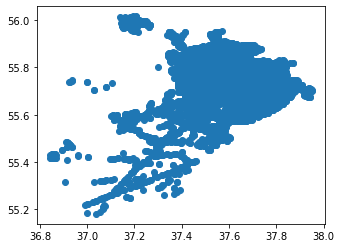

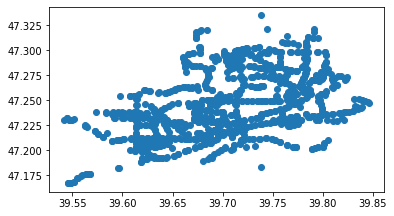

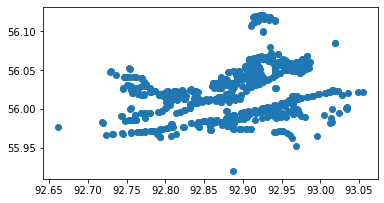

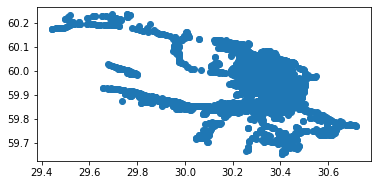

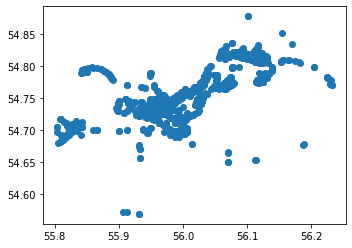

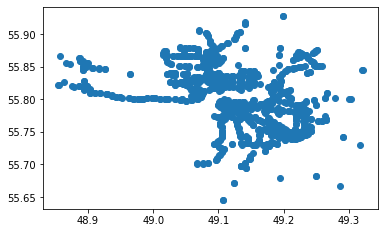

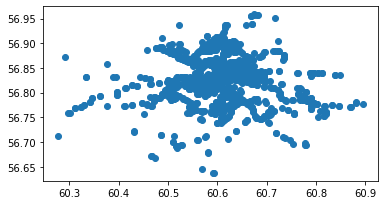

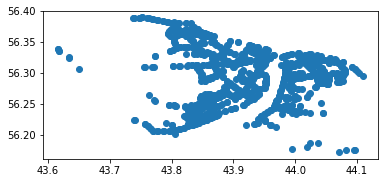

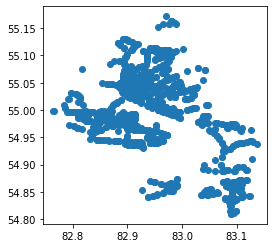

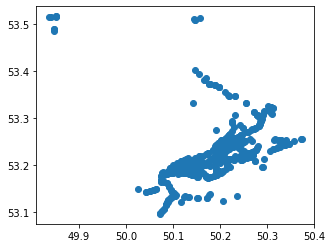

In [671]:
test_bus_stops = bound_obj(test_gdf, get_bbox_bus_stops)

In [677]:
test_gdf['bus_stops_count_200'] = [
    intersections(name, buffer, test_bus_stops) for name, buffer in tqdm(zip(test_gdf['name'], test_gdf['buffer_200']))
]

0it [00:00, ?it/s]

In [678]:
test_gdf['center_dist'] = [
    center_dist(name, point) for name, point in tqdm(zip(test_gdf['name'], test_gdf['geometry']))
]

0it [00:00, ?it/s]

In [680]:
test_gdf['nearest_bus_stop'] = [
    nearest_object(name, point, test_bus_stops) for name, point in tqdm(zip(test_gdf['name'], test_gdf['geometry']))
]

0it [00:00, ?it/s]

CPU times: user 4.18 s, sys: 43.9 ms, total: 4.22 s
Wall time: 14.9 s


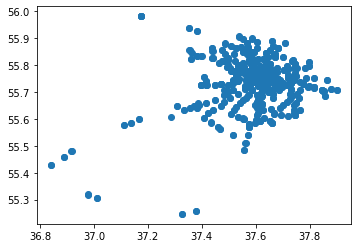

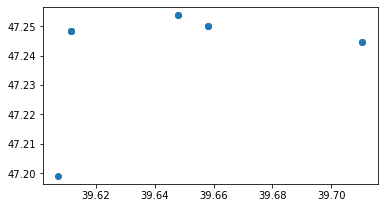

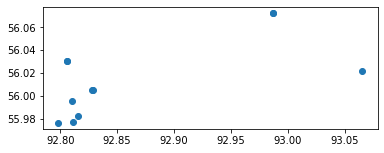

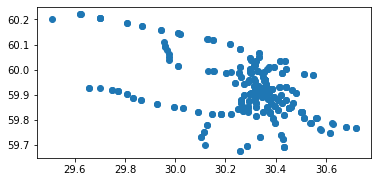

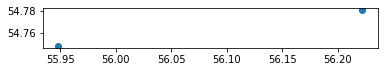

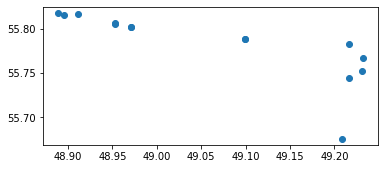

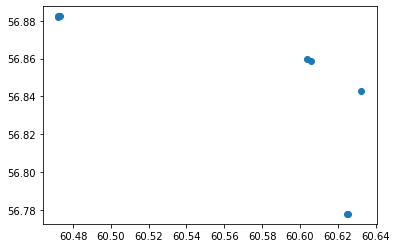

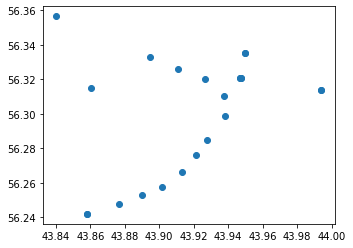

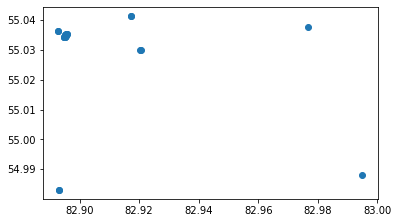

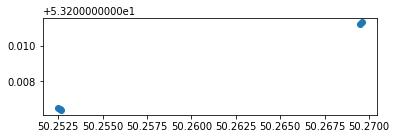

In [681]:
%%time
test_railway_stops = bound_obj(test_gdf, get_railway_stops)

In [682]:
test_gdf['railway_stops_count_300'] = [
    intersections(name, buffer, test_railway_stops) for name, buffer in tqdm(zip(test_gdf['name'], test_gdf['buffer_300']))
]

0it [00:00, ?it/s]

In [683]:
test_gdf['nearest_railway_stop'] = [
    nearest_object(name, point, test_railway_stops) for name, point in tqdm(zip(test_gdf['name'], test_gdf['geometry']))
]

0it [00:00, ?it/s]

In [684]:
test_gdf.head()

,point_id,lon,lat,geometry,name,buffer_200,buffer_300,buffer_500,bus_stops_count_200,center_dist,nearest_bus_stop,railway_stops_count_300,nearest_railway_stop
0,F4lXR1cG,37.681242,55.748040,POINT (37.68124 55.74804),Москва,"POLYGON ((37.68001 55.74667, 37.67978 55.74674...","POLYGON ((37.67940 55.74598, 37.67905 55.74610...","POLYGON ((37.67817 55.74461, 37.67759 55.74480...",3,4012,168,7,57
1,4LJu4GTf,60.580910,56.795860,POINT (60.58091 56.79586),городской округ Екатеринбург,"POLYGON ((60.57857 56.79481, 60.57840 56.79494...","POLYGON ((60.57740 56.79428, 60.57714 56.79448...","POLYGON ((60.57506 56.79323, 60.57462 56.79356...",0,5097,201,0,3365
2,kLuAAN3s,37.598614,55.781357,POINT (37.59861 55.78136),Москва,"POLYGON ((37.59739 55.77998, 37.59716 55.78006...","POLYGON ((37.59678 55.77930, 37.59643 55.77941...","POLYGON ((37.59555 55.77793, 37.59497 55.77811...",2,3640,21,2,163
3,OxQHvaNu,37.794051,55.717468,POINT (37.79405 55.71747),Москва,"POLYGON ((37.79282 55.71610, 37.79259 55.71617...","POLYGON ((37.79220 55.71541, 37.79185 55.71553...","POLYGON ((37.79097 55.71404, 37.79039 55.71423...",4,11683,52,2,54
4,paQsTa1K,49.213026,55.748290,POINT (49.21303 55.74829),городской округ Казань,"POLYGON ((49.21124 55.74706, 49.21103 55.74717...","POLYGON ((49.21034 55.74645, 49.21003 55.74660...","POLYGON ((49.20855 55.74522, 49.20804 55.74548...",2,6742,55,0,456


In [685]:
train_df = gdf[[
    'bus_stops_count_200',
    'center_dist',
    'nearest_bus_stop',
    'railway_stops_count_300',
    'nearest_railway_stop'
]]
train_df.head(3)

,bus_stops_count_200,center_dist,nearest_bus_stop,railway_stops_count_300,nearest_railway_stop
0,4,11059,25,5,127
1,5,10469,46,2,178
2,3,5803,67,0,2680


In [686]:
test_df = test_gdf[[
    'bus_stops_count_200',
    'center_dist',
    'nearest_bus_stop',
    'railway_stops_count_300',
    'nearest_railway_stop'
]]
test_df.head(3)

,bus_stops_count_200,center_dist,nearest_bus_stop,railway_stops_count_300,nearest_railway_stop
0,3,4012,168,7,57
1,0,5097,201,0,3365
2,2,3640,21,2,163


In [763]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, train[['target']])
model = LinearRegression().fit(X_train, y_train)
mean_absolute_error(y_valid, model.predict(X_valid))

0.7182604297358209

In [755]:
scaled_train = StandardScaler().fit_transform(train_df.values)
scaled_test = StandardScaler().fit_transform(test_df.values)

In [775]:
X_train, X_valid, y_train, y_valid = train_test_split(scaled_train, train['target'].values)
model = LinearRegression().fit(X_train, y_train)
mean_absolute_error(y_valid, model.predict(X_valid))

0.7370037532326368

In [779]:
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = model.predict(X_valid)
submission.to_csv('data/my_submission_01.csv', index=False)